# Capstone Project - Restaurant Recommendation System
The goal of this notebook is to provide data driven food venue recommendation in Jakarta, Indonesia. The report should give an insight for traveler to understand the location on restaurant or any other activity in the area. Notebook contain several parts :

1. Data Acquisition & Cleansing - Postal Code & Coordinates
2. Data Acquisition & Cleansing - Jakarta Venues
3. Descriptive Analysis
4. Clustering Neighborhood
5. Conclusion

In [1]:
# Import Libraries
import pandas as pd
import os,sys
import urllib
import requests 
import io
import numpy as np
from urllib.request import urlopen
from bs4 import BeautifulSoup
#!conda install -c conda-forge folium=0.5.0 --yes 
import folium
from geopy.geocoders import Nominatim
from IPython.display import HTML
import base64
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

print('Libraries imported.')

Libraries imported.


## 1. Data Acquisition & Cleansing - Postal Code & Coordinates

Jakarta subdistricts and postal code data has been retrieved from my previous project.

Data Source: 
- https://www.kemendagri.go.id/page/read/40/permendagri-no137-tahun-2017
- http://www.posindonesia.co.id/

In [3]:
df_jakarta_1 = pd.read_excel('Jakarta_Postal_Code.xlsx', index_col=None)
df_jakarta_1

,Subdistricts,Districts,Regency,Province,PostalCode
0,GAMBIR,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10110
1,KEBON KELAPA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10120
2,PETOJO UTARA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10130
3,DURI PULO,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10140
4,CIDENG,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10150
...,...,...,...,...,...
262,PULAU PARI,KEPULAUAN SERIBU SELATAN,KEPULAUAN SERIBU,DKI JAKARTA,14520
263,PULAU TIDUNG,KEPULAUAN SERIBU SELATAN,KEPULAUAN SERIBU,DKI JAKARTA,14520
264,PULAU PANGGANG,KEPULAUAN SERIBU UTARA,KEPULAUAN SERIBU,DKI JAKARTA,14530
265,PULAU HARAPAN,KEPULAUAN SERIBU UTARA,KEPULAUAN SERIBU,DKI JAKARTA,14540


### Get Long & Lat for each zip code
Get Coordinate for each zip code using geolocator API coordinate

In [ ]:
import time
geolocator = Nominatim(user_agent="jakarta_explorer")
df_jakarta_1 = df_jakarta_2
idx=-1
for kelurahan, kabupaten, zipcode in zip(df_jakarta_1['Subdistricts'], \
                                         df_jakarta_1['Regency'], df_jakarta_1['PostalCode'] ):
    idx= idx+1
    #alamat = kelurahan + ", " + "Jakarta, Indonesia"
    alamat = str(zipcode) + " " + "Jakarta, Indonesia"
    try :
        location = geolocator.geocode(alamat)
        rowIndex = df_jakarta_2.index[idx]
        print(rowIndex)
        print(alamat)
        print("====>", location)
        print("====>",(location.latitude, location.longitude))
        df_jakarta_2.loc[rowIndex, 'Latitude'] = location.latitude
        df_jakarta_2.loc[rowIndex, 'Longitude'] = location.longitude
        df_jakarta_2.loc[rowIndex, 'Note'] = alamat
        time.sleep(1) # Delay every seconds 
    except:
        continue

In [4]:
df_jakarta_2

NameError: name 'df_jakarta_2' is not defined

In [ ]:
# arrange columns
df_jakarta_1 = pd.read_excel('Jakarta_Postal_Code.xlsx', index_col=None)
df_jakarta_1 = df_jakarta_1[['Subdistricts','Districts']]

df_jakarta_3 = pd.merge(df_jakarta_2,df_jakarta_1,on='Subdistricts',how='left')
df_jakarta_3 = df_jakarta_3[['Subdistricts','Districts','Regency', 'Province','PostalCode','Longitude','Latitude']]

In [ ]:
df_jakarta_3

### Find Null value in dataframe
Dataframe check for any null value. Do neccessary step to clean up 

In [ ]:
df_jakarta_3.isnull().sum()

In [ ]:
#save result
df_jakarta_3.to_csv('Jakarta_Postal_Code_Longlat.csv',index=False)

print ("saved!")

In [5]:
# checkpoint
df_jakarta_3 = pd.read_csv('Jakarta_Postal_Code_Longlat.csv')
df_jakarta_3

,Subdistricts,Districts,Regency,Province,PostalCode,Longitude,Latitude
0,GAMBIR,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10110,106.826741,-6.176077
1,KEBON KELAPA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10120,106.827249,-6.162689
2,PETOJO UTARA,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10130,106.818619,-6.165015
3,DURI PULO,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10140,106.810215,-6.165196
4,CIDENG,GAMBIR,JAKARTA PUSAT,DKI JAKARTA,10150,106.812574,-6.167774
...,...,...,...,...,...,...,...
262,PULAU PARI,KEPULAUAN SERIBU SELATAN,KEPULAUAN SERIBU,DKI JAKARTA,14520,106.503420,-5.800607
263,PULAU TIDUNG,KEPULAUAN SERIBU SELATAN,KEPULAUAN SERIBU,DKI JAKARTA,14520,106.503420,-5.800607
264,PULAU PANGGANG,KEPULAUAN SERIBU UTARA,KEPULAUAN SERIBU,DKI JAKARTA,14530,106.827183,-6.175394
265,PULAU HARAPAN,KEPULAUAN SERIBU UTARA,KEPULAUAN SERIBU,DKI JAKARTA,14540,106.827183,-6.175394


### Visualize Jakarta Subdistricts

In [6]:
# Get jakarta coordinate
import time
geolocator = Nominatim(user_agent="jakarta_explorer")
location = geolocator.geocode("Jakarta Indonesia")
latitude=location.latitude
longitude=location.longitude
print("====>", location)
print("====>",(location.latitude, location.longitude))

====> Daerah Khusus Ibukota Jakarta, Indonesia
====> (-6.1753942, 106.827183)


In [8]:
# create map of Jakarta using latitude and longitude values above
jakarta_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, postalcode in zip(df_jakarta_3['Latitude'], df_jakarta_3['Longitude'],  df_jakarta_3['Subdistricts'], df_jakarta_3['PostalCode']):
    label = '{},{}'.format(neighborhood,postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(jakarta_map)
jakarta_map

## 2. Data Acquisition - Jakarta Venues

### Get Venues List

In [ ]:
# My first ID
CLIENT_ID = #ID 
CLIENT_SECRET = #Secret 
ACCESS_TOKEN = #Access Token 
VERSION = '20180604'
LIMIT = 500
RADIUS = 500
print('Your credentails:')
print('CLIENT_ID: ' + "ID")
print('CLIENT_SECRET: ' + "Secret")

In [ ]:
# Get list of venue on 500 meter radius, limit by limit value
# Get venue function.
def getVenueList(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format( \
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # insert result into dataframe
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['id'],
            v['venue']['categories'][0]['name']) for v in results])

    jakarta_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    jakarta_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'VenueID',     
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue CatID', 
                  'Venue Category']
    
    return(jakarta_venues)

In [ ]:
# Get Jakarta Venue using API
jakarta_venuelist= getVenueList(names=df_jakarta_3['Subdistricts'],
                                   latitudes=df_jakarta_3['Latitude'],
                                   longitudes=df_jakarta_3['Longitude'])

In [9]:
# checkpoint
jakarta_venuelist = pd.read_excel('jakarta_venuelist.xlsx')
jakarta_venuelist

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue Category
0,GAMBIR,-6.176077,106.826741,4e8a3ffbd3e3304c8afca029,National Monument Park,-6.175331,106.827047,4bf58dd8d48988d163941735,Park
1,GAMBIR,-6.176077,106.826741,4b84944df964a520ac3c31e3,Museum Nasional Indonesia,-6.176206,106.822854,4bf58dd8d48988d181941735,Museum
2,GAMBIR,-6.176077,106.826741,4fa487c2e4b0244336041fe7,Jogging Track MONAS,-6.175537,106.827134,4bf58dd8d48988d106941735,Track
3,GAMBIR,-6.176077,106.826741,4ed1a2a1f5b9832adbbcff90,Lapangan Silang Monas,-6.177649,106.826851,4bf58dd8d48988d164941735,Plaza
4,GAMBIR,-6.176077,106.826741,51047707e4b0059ce06c2cf0,Starbucks,-6.177147,106.830818,4bf58dd8d48988d1e0931735,Coffee Shop
...,...,...,...,...,...,...,...,...,...
4737,PULAU KELAPA,-6.175394,106.827183,4e2a5d3b18508ec753d1299b,Silang Monas Timur,-6.173089,106.829242,4bf58dd8d48988d163941735,Park
4738,PULAU KELAPA,-6.175394,106.827183,4c4025facc410f476730a961,Rotiboy Bakeshoppe,-6.177046,106.830792,4bf58dd8d48988d1bc941735,Cupcake Shop
4739,PULAU KELAPA,-6.175394,106.827183,4fdb0bbde4b0d1917d615de4,"Kampung Daun,Lembang Bandung",-6.173472,106.824743,4bf58dd8d48988d17a941735,Cajun / Creole Restaurant
4740,PULAU KELAPA,-6.175394,106.827183,4e69f41188772457c438c99e,Soto Kriuk,-6.177241,106.830933,4bf58dd8d48988d1dd931735,Soup Place


In [10]:
# drop duplicate data
jakarta_venuelist_clean = jakarta_venuelist.drop_duplicates(subset='VenueID', keep="first")
jakarta_venuelist_clean

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue Category
0,GAMBIR,-6.176077,106.826741,4e8a3ffbd3e3304c8afca029,National Monument Park,-6.175331,106.827047,4bf58dd8d48988d163941735,Park
1,GAMBIR,-6.176077,106.826741,4b84944df964a520ac3c31e3,Museum Nasional Indonesia,-6.176206,106.822854,4bf58dd8d48988d181941735,Museum
2,GAMBIR,-6.176077,106.826741,4fa487c2e4b0244336041fe7,Jogging Track MONAS,-6.175537,106.827134,4bf58dd8d48988d106941735,Track
3,GAMBIR,-6.176077,106.826741,4ed1a2a1f5b9832adbbcff90,Lapangan Silang Monas,-6.177649,106.826851,4bf58dd8d48988d164941735,Plaza
4,GAMBIR,-6.176077,106.826741,51047707e4b0059ce06c2cf0,Starbucks,-6.177147,106.830818,4bf58dd8d48988d1e0931735,Coffee Shop
...,...,...,...,...,...,...,...,...,...
4637,KAMAL MUARA,-6.116722,106.752497,5146b243e4b092571b1822a6,Ozone Leisure Mall,-6.112542,106.752599,4bf58dd8d48988d1fd941735,Shopping Mall
4662,PULAU PARI,-5.800607,106.503420,4d295a74467d6ea8053dcf95,Dermaga Pulau Tidung,-5.799773,106.499664,4bf58dd8d48988d1e0941735,Harbor / Marina
4663,PULAU PARI,-5.800607,106.503420,4f1c12dbe4b05c50e33d18fc,Tidung seafood,-5.800490,106.503841,4bf58dd8d48988d1ce941735,Seafood Restaurant
4664,PULAU PARI,-5.800607,106.503420,51f79f4b498e72e98767c61b,Bamboo Sea Food Tidung Island,-5.800726,106.504650,4bf58dd8d48988d1ce941735,Seafood Restaurant


In [11]:
# filter venue category to restaurant, cafetaria, cafe
jakarta_venuelist_filter = jakarta_venuelist_clean[jakarta_venuelist_clean['Venue Category'].str.contains("Restaurant|Café|cafe|cafetaria")]
jakarta_venuelist_filter

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue Category
6,GAMBIR,-6.176077,106.826741,595f9e27c824ae6362812504,McDonald's,-6.176663,106.830650,4bf58dd8d48988d16e941735,Fast Food Restaurant
7,GAMBIR,-6.176077,106.826741,4e16b2f1b0fb42f98734fc9d,Sate Senayan,-6.176699,106.829012,4deefc054765f83613cdba6f,Indonesian Restaurant
13,GAMBIR,-6.176077,106.826741,56c72378cd1080d7a15257d6,McDonald’s,-6.177294,106.830890,4bf58dd8d48988d16e941735,Fast Food Restaurant
17,GAMBIR,-6.176077,106.826741,4d1a9e87eab1224b4bd7cbe2,Pagi Sore Masakan Padang,-6.173674,106.828488,4deefc054765f83613cdba6f,Indonesian Restaurant
23,GAMBIR,-6.176077,106.826741,4fdb0bbde4b0d1917d615de4,"Kampung Daun,Lembang Bandung",-6.173472,106.824743,4bf58dd8d48988d17a941735,Cajun / Creole Restaurant
...,...,...,...,...,...,...,...,...,...
4631,KAMAL MUARA,-6.116722,106.752497,51177234e4b0f8a4cb83fe6e,Burger King,-6.116712,106.756090,4bf58dd8d48988d16e941735,Fast Food Restaurant
4632,KAMAL MUARA,-6.116722,106.752497,565e7c82498e44e35159ffe8,"Hachimaki Ramen & Sushi, Ruko The Metro Blok 6...",-6.114048,106.755051,4bf58dd8d48988d111941735,Japanese Restaurant
4635,KAMAL MUARA,-6.116722,106.752497,56ee6f9c498e752401d3f927,Boon Tong Kee,-6.114322,106.755102,4bf58dd8d48988d145941735,Chinese Restaurant
4663,PULAU PARI,-5.800607,106.503420,4f1c12dbe4b05c50e33d18fc,Tidung seafood,-5.800490,106.503841,4bf58dd8d48988d1ce941735,Seafood Restaurant


In [12]:
# additional venue category
jakarta_venuelist_filter2 = jakarta_venuelist_clean[jakarta_venuelist_clean['Venue Category'].str.contains
                                                    ("Bakery| Bar| BBQ Joint| Beer Bar| Beer Garden| Bistro | Breakfast Spot| Bubble Tea Shop| Burger Joint| Cocktail Bar| Coffee Shop| Cupcake Shop| Dessert Shop| Donut Shop| Fish & Chips Shop| Food| Food & Drink Shop| Food Court| Food Stand| Food Truck| Fried Chicken Joint| Frozen Yogurt Shop| Gastropub| Hotel Bar| Indonesian Meatball Place| Juice Bar| Karaoke Bar| Lounge| Noodle House| Pet Café| Pizza Place| Pub| Salad Place| Sandwich Place| Snack Place| Soup Place| Souvlaki Shop| Steakhouse| Street Food Gathering| Whisky Bar| Wine Bar| Wings Joint")]
jakarta_venuelist_filter2

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue Category
6,GAMBIR,-6.176077,106.826741,595f9e27c824ae6362812504,McDonald's,-6.176663,106.830650,4bf58dd8d48988d16e941735,Fast Food Restaurant
13,GAMBIR,-6.176077,106.826741,56c72378cd1080d7a15257d6,McDonald’s,-6.177294,106.830890,4bf58dd8d48988d16e941735,Fast Food Restaurant
50,KEBON KELAPA,-6.162689,106.827249,54250803498ecea0c862aa08,Re•juve,-6.161063,106.831415,4bf58dd8d48988d112941735,Juice Bar
52,KEBON KELAPA,-6.162689,106.827249,51d3aaff498ed984b4c1bcf1,KFC,-6.166763,106.828845,4bf58dd8d48988d16e941735,Fast Food Restaurant
72,PETOJO UTARA,-6.165015,106.818619,4c56765b2308be9a6304576c,McDonald's,-6.160730,106.819710,4bf58dd8d48988d16e941735,Fast Food Restaurant
...,...,...,...,...,...,...,...,...,...
4544,PEJAGALAN,-6.121104,106.780021,507e8514e4b08b12cbc896d8,KFC,-6.124348,106.781674,4bf58dd8d48988d16e941735,Fast Food Restaurant
4548,PEJAGALAN,-6.121104,106.780021,4c07830acf8c76b069133c65,Shihlin Taiwan Street Snacks,-6.124230,106.781609,4bf58dd8d48988d16e941735,Fast Food Restaurant
4615,KAPUK MUARA,-6.123993,106.762436,5120c3e6e4b00c9529681fb4,Burger King,-6.122637,106.761300,4bf58dd8d48988d16e941735,Fast Food Restaurant
4626,KAMAL MUARA,-6.116722,106.752497,50dd942be4b050d7c54979ec,Provence Bakery,-6.116220,106.756581,4bf58dd8d48988d16a941735,Bakery


### Get Venue Score

In [ ]:
# Get venue score from list of Jakarta venue list above.
def getVenuescore(dataframe,start,stop):
    newdf=dataframe.iloc[start:stop+1]
    idx=-1;
    for VenueID, VenueName in zip(dataframe['VenueID'], dataframe['Venue']):
        idx=idx+1
        if start <= idx <= stop:
            printVenue = str(idx) + ", " + VenueID + ", " + VenueName
            #print(printVenue)

            url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(VenueID,\
                        CLIENT_ID,CLIENT_SECRET,VERSION)
            venScore = 0.00 # initialize Venue Score to zero

            # Process results
            try:
                result = requests.get(url).json()
                venScore  = result['response']['venue']['rating']
            except: 
                pass
            newdf.loc[dataframe.index[idx], 'Venue Score'] = venScore
            printvenueandscore = printVenue + ", " + str(venScore)
            print(printvenueandscore )
        else:
            continue
    return(newdf)

In [ ]:
# Get Jakarta Venue Score using Foursquare API
#jakarta_venue_score1 = getVenuescore(jakarta_venuelist_filter,0,50)
jakarta_venue_score1.to_csv("jakarta_venue_score1.csv")

In [ ]:
#jakarta_venue_score2 = getVenuescore(jakarta_venuelist,51,350)
jakarta_venue_score2.to_csv("jakarta_venue_score2.csv")

In [ ]:
#jakarta_venue_score3 = getVenuescore(jakarta_venuelist,351,500)
jakarta_venue_score3.to_csv("jakarta_venue_score3.csv")

In [ ]:
#jakarta_venue_score4 = getVenuescore(jakarta_venuelist,501,1000)
jakarta_venue_score4.to_csv("jakarta_venue_score4.csv")

In [ ]:
#jakarta_venue_score5 = getVenuescore(jakarta_venuelist,1001,1132)
jakarta_venue_score5.to_csv("jakarta_venue_score5.csv")

In [ ]:
#jakarta_venue_score6 = getVenuescore(jakarta_venuelist_filter2,0,289)
jakarta_venue_score6.to_csv("jakarta_venue_score6.csv")

In [ ]:
#Append rating venue data 
import glob

path = #input local path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

jakarta_venuescore = pd.concat(li, axis=0, ignore_index=True)
jakarta_venuescore

In [13]:
# checkpoint

#jakarta_venuescore.to_excel('jakarta_venuescore.xlsx',index = False)
jakarta_venuescore = pd.read_excel('jakarta_venuescore.xlsx', index = False)
jakarta_venuescore

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue Category,Venue Score
0,PETOJO UTARA,-6.165015,106.818619,4c5ec83085a1e21e0c005d11,A&W,-6.162552,106.819734,4bf58dd8d48988d14e941735,American Restaurant,5.8
1,GELORA,-6.218325,106.800884,55043762498e9eb5c21cc94f,Spectrum,-6.221643,106.798856,4bf58dd8d48988d14e941735,American Restaurant,8.0
2,PETOJO UTARA,-6.165015,106.818619,4c5ec83085a1e21e0c005d11,A&W,-6.162552,106.819734,4bf58dd8d48988d14e941735,American Restaurant,5.8
3,SENEN,-6.178920,106.838963,4ce649d9baa6a1cdf778206c,American Hamburger (AH),-6.176801,106.841166,4bf58dd8d48988d14e941735,American Restaurant,6.6
4,PASAR BARU,-6.167750,106.836174,4f617e70e4b0dd26f19a1f95,A&W Golden Truly,-6.163381,106.836243,4bf58dd8d48988d14e941735,American Restaurant,7.9
...,...,...,...,...,...,...,...,...,...,...
1006,SETIABUDI,-6.215600,106.827757,4e05164981dc6d6d36a53e3d,Destination,-6.214769,106.830197,4bf58dd8d48988d123941735,Wine Bar,6.4
1007,KARET TENGSIN,-6.208545,106.818470,570268bc498ef62a8a52e49c,Wingstop,-6.208928,106.818086,4bf58dd8d48988d14c941735,Wings Joint,7.6
1008,CEMPAKA BARU,-6.168070,106.863965,4e01e268c65b896d116ec743,Ayam Bakar Arjuna,-6.163825,106.862669,4bf58dd8d48988d14c941735,Wings Joint,7.4
1009,HARAPAN MULYA,-6.168070,106.863965,4e01e268c65b896d116ec743,Ayam Bakar Arjuna,-6.163825,106.862669,4bf58dd8d48988d14c941735,Wings Joint,7.4


In [14]:
jakarta_venuescore_filter=jakarta_venuescore.loc[jakarta_venuescore['Venue Score'] >0.0]
jakarta_venuescore_filter

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue Category,Venue Score
0,PETOJO UTARA,-6.165015,106.818619,4c5ec83085a1e21e0c005d11,A&W,-6.162552,106.819734,4bf58dd8d48988d14e941735,American Restaurant,5.8
1,GELORA,-6.218325,106.800884,55043762498e9eb5c21cc94f,Spectrum,-6.221643,106.798856,4bf58dd8d48988d14e941735,American Restaurant,8.0
2,PETOJO UTARA,-6.165015,106.818619,4c5ec83085a1e21e0c005d11,A&W,-6.162552,106.819734,4bf58dd8d48988d14e941735,American Restaurant,5.8
3,SENEN,-6.178920,106.838963,4ce649d9baa6a1cdf778206c,American Hamburger (AH),-6.176801,106.841166,4bf58dd8d48988d14e941735,American Restaurant,6.6
4,PASAR BARU,-6.167750,106.836174,4f617e70e4b0dd26f19a1f95,A&W Golden Truly,-6.163381,106.836243,4bf58dd8d48988d14e941735,American Restaurant,7.9
...,...,...,...,...,...,...,...,...,...,...
1006,SETIABUDI,-6.215600,106.827757,4e05164981dc6d6d36a53e3d,Destination,-6.214769,106.830197,4bf58dd8d48988d123941735,Wine Bar,6.4
1007,KARET TENGSIN,-6.208545,106.818470,570268bc498ef62a8a52e49c,Wingstop,-6.208928,106.818086,4bf58dd8d48988d14c941735,Wings Joint,7.6
1008,CEMPAKA BARU,-6.168070,106.863965,4e01e268c65b896d116ec743,Ayam Bakar Arjuna,-6.163825,106.862669,4bf58dd8d48988d14c941735,Wings Joint,7.4
1009,HARAPAN MULYA,-6.168070,106.863965,4e01e268c65b896d116ec743,Ayam Bakar Arjuna,-6.163825,106.862669,4bf58dd8d48988d14c941735,Wings Joint,7.4


## 3. Descriptive Analysis

### Top 10 Neighborhood with Highest Rating Food Place

In [15]:
# Group dataframe by neighborhood. 
# Show top 10
jakarta_venuescore_filter.groupby(['Neighborhood'])['Venue Score'].mean().sort_values(ascending=False)[:10]

top_10_neighborhood=jakarta_venuescore_filter.groupby(['Neighborhood'])['Venue Score'].mean().sort_values(ascending=False)[:10]
top_10_neighborhood

Neighborhood
BUKIT DURI             9.00
GUNTUR                 8.60
KELAPA GADING BARAT    8.40
PETUKANGAN SELATAN     8.40
PETOGOGAN              8.30
SENAYAN                8.26
SELONG                 8.20
BIDARACINA             8.20
PONDOK BAMBU           8.20
PONDOK PINANG          8.20
Name: Venue Score, dtype: float64

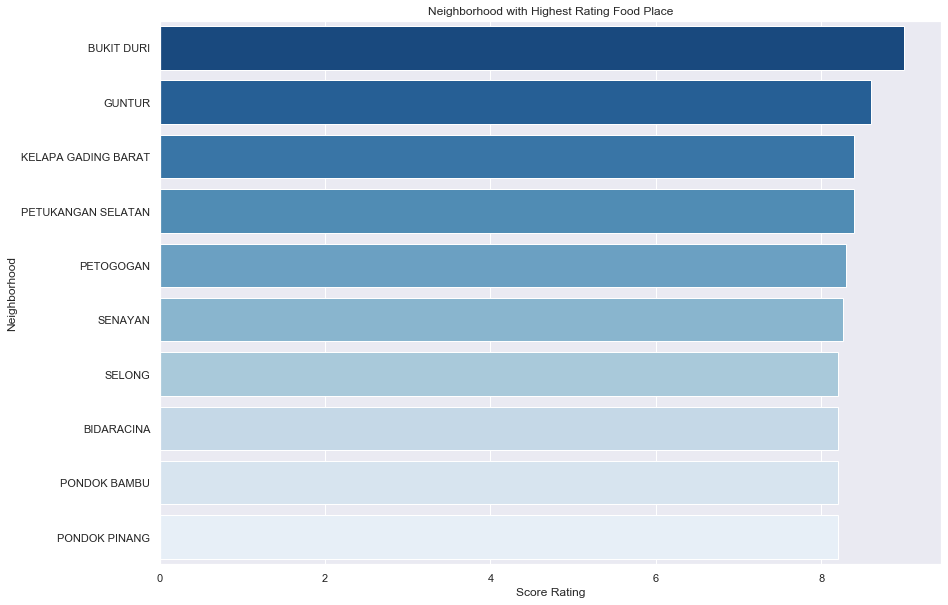

In [16]:
import matplotlib.pyplot as plt
pal = sns.color_palette("Blues_r", len(top_10_neighborhood))
sns.set(rc={'figure.figsize':(14,10)})
axis = sns.barplot(data = top_10_neighborhood.reset_index(), x = 'Venue Score', y = 'Neighborhood',palette=pal)
axis.set_title("Neighborhood with Highest Rating Food Place")
axis.set_xlabel('Score Rating')
plt.show()

### Top 10 Venue Category in Jakarta

In [17]:
# Group dataframe by Venue Category. 
# Show top 10
jakarta_venuescore_filter.groupby(['Venue Category'])['Venue Score'].mean().sort_values(ascending=False)[:10]

top_10_venue=jakarta_venuescore_filter.groupby(['Venue Category'])['Venue Score'].mean().sort_values(ascending=False)[:10]
top_10_venue

Venue Category
Tapas Restaurant         9.0
Buffet                   8.9
Beer Bar                 8.8
Udon Restaurant          8.5
Manadonese Restaurant    8.4
Tea Room                 8.4
Sandwich Place           8.3
Burger Joint             8.2
Halal Restaurant         8.1
Salad Place              8.1
Name: Venue Score, dtype: float64

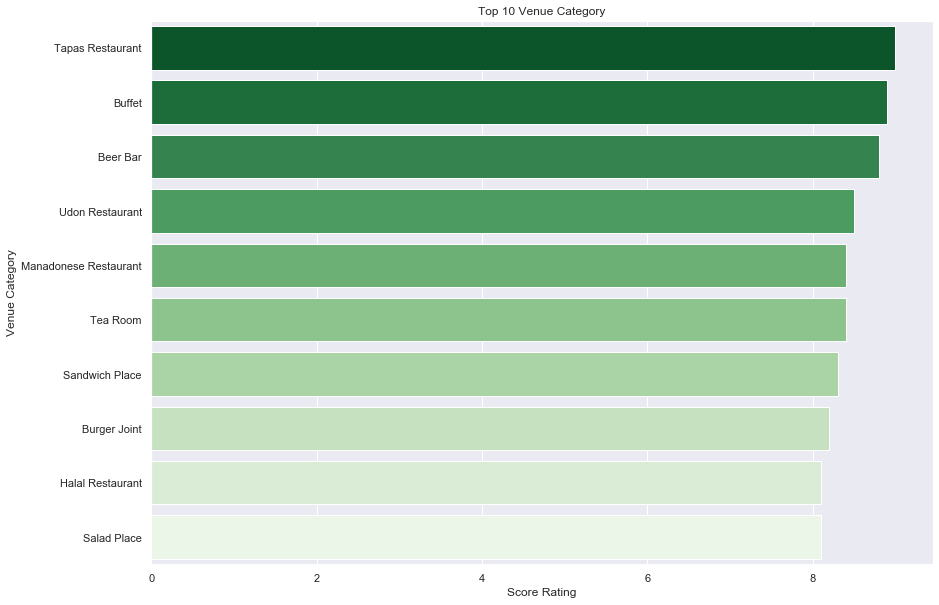

In [18]:
import matplotlib.pyplot as plt
pal = sns.color_palette("Greens_r", len(top_10_venue))
sns.set(rc={'figure.figsize':(14,10)})
axis = sns.barplot(data = top_10_venue.reset_index(), x = 'Venue Score', y = 'Venue Category',palette=pal)
axis.set_title("Top 10 Venue Category")
axis.set_xlabel('Score Rating')
plt.show()

### top 10 category x neighborhood

In [19]:
# Group dataframe by Venue Category. 
# Show top 100
jakarta_venuescore_filter.groupby(['Venue Category','Neighborhood'])['Venue Score'].mean().sort_values(ascending=False)[:100]

top_10_venue_category=jakarta_venuescore_filter.groupby(['Venue Category','Neighborhood'])['Venue Score'].mean().sort_values(ascending=False)[:100]
top_10_venue_category

Venue Category             Neighborhood 
Tapas Restaurant           MENTENG          9.000000
Fast Food Restaurant       BUKIT DURI       9.000000
Wine Bar                   SENAYAN          9.000000
Buffet                     PEGANGSAAN       8.900000
Comfort Food Restaurant    CIPETE UTARA     8.900000
                                              ...   
Soup Place                 DURI PULO        7.866667
Japanese Restaurant        CIKINI           7.850000
Café                       CIKINI           7.850000
Middle Eastern Restaurant  KARET TENGSIN    7.800000
Noodle House               TAMAN SARI       7.800000
Name: Venue Score, Length: 100, dtype: float64

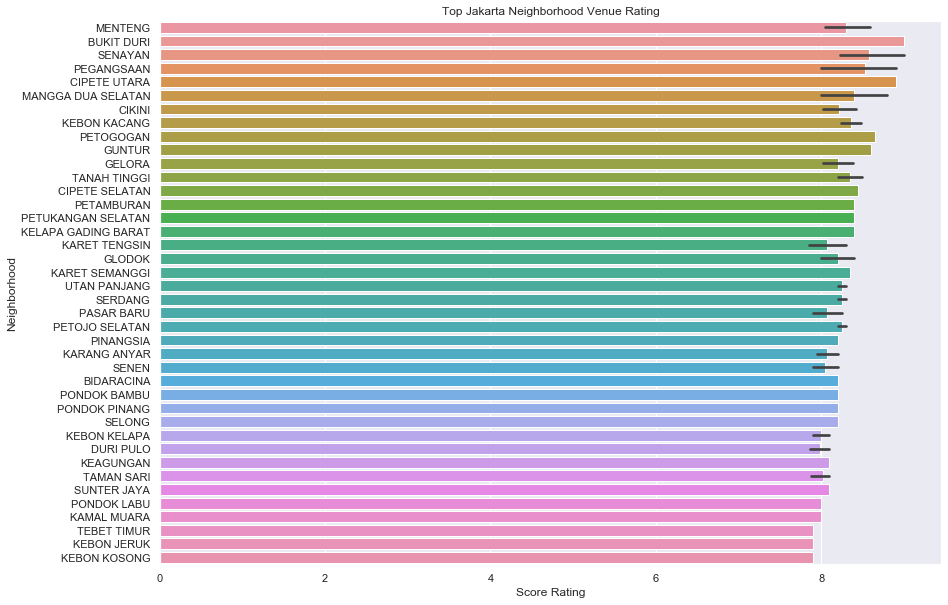

In [20]:
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(14,10)})
axis = sns.barplot(data = top_10_venue_category.reset_index(), x = 'Venue Score', y = 'Neighborhood')
axis.set_title("Top Jakarta Neighborhood Venue Rating")
axis.set_xlabel('Score Rating')
plt.show()

### top 10 most common venues 

In [21]:
# Jakarta Venue Group By Neighborhood
jakarta_venuescore_filter.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue CatID,Venue Category,Venue Score
Neighborhood,,,,,,,,,
BALEKAMBANG,2,2,2,2,2,2,2,2,2
BALI MESTER,5,5,5,5,5,5,5,5,5
BANGKA,7,7,7,7,7,7,7,7,7
BATUAMPAR,4,4,4,4,4,4,4,4,4
BENDUNGAN HILIR,14,14,14,14,14,14,14,14,14
...,...,...,...,...,...,...,...,...,...
TANJUNG BARAT,2,2,2,2,2,2,2,2,2
TANJUNG DUREN SELATAN,2,2,2,2,2,2,2,2,2
TEBET TIMUR,1,1,1,1,1,1,1,1,1


In [22]:
# Print Unique Categories on Neighborhood
print('There are {} uniques categories.'.format(len(jakarta_venuescore_filter['Venue Category'].unique())))

There are 89 uniques categories.


In [23]:
# Use one hot encoding
jakarta_onehot = pd.get_dummies(jakarta_venuescore_filter[['Venue Category']], prefix="", prefix_sep="")
jakarta_onehot

,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Balinese Restaurant,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,...,Tapas Restaurant,Tea Room,Thai Restaurant,Thrift / Vintage Store,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [24]:
# Put neighborhood back on to dataframe
jakarta_onehot['Neighborhood'] = jakarta_venuescore_filter['Neighborhood'] 

# Rearange neighborhood columns
fixed_columns = [jakarta_onehot.columns[-1]] + list(jakarta_onehot.columns[:-1])
jakarta_onehot = jakarta_onehot[fixed_columns]

jakarta_onehot

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Balinese Restaurant,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,...,Tapas Restaurant,Tea Room,Thai Restaurant,Thrift / Vintage Store,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint
0,PETOJO UTARA,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,GELORA,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,PETOJO UTARA,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,SENEN,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,PASAR BARU,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,SETIABUDI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1007,KARET TENGSIN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1008,CEMPAKA BARU,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1009,HARAPAN MULYA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [25]:
jakarta_grouped = jakarta_onehot.groupby('Neighborhood').mean().reset_index()
jakarta_grouped

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Balinese Restaurant,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,...,Tapas Restaurant,Tea Room,Thai Restaurant,Thrift / Vintage Store,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint
0,BALEKAMBANG,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BALI MESTER,0.0,0.0,0.0,0.20,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BANGKA,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BATUAMPAR,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BENDUNGAN HILIR,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,TANJUNG BARAT,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127,TANJUNG DUREN SELATAN,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128,TEBET TIMUR,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129,TEGAL ALUR,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
num_top_venues = 10
for neigh in jakarta_grouped['Neighborhood']:
    print("----"+neigh+"----")
    temp = jakarta_grouped[jakarta_grouped['Neighborhood'] == neigh].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----BALEKAMBANG----
                   venue  freq
0   Fast Food Restaurant   1.0
1    American Restaurant   0.0
2            Salad Place   0.0
3       Ramen Restaurant   0.0
4                  Plaza   0.0
5            Pizza Place   0.0
6              Pet Store   0.0
7  Padangnese Restaurant   0.0
8           Noodle House   0.0
9              Nightclub   0.0


----BALI MESTER----
                   venue  freq
0   Fast Food Restaurant   0.8
1                 Bakery   0.2
2    American Restaurant   0.0
3    Moroccan Restaurant   0.0
4             Restaurant   0.0
5       Ramen Restaurant   0.0
6                  Plaza   0.0
7            Pizza Place   0.0
8              Pet Store   0.0
9  Padangnese Restaurant   0.0


----BANGKA----
                     venue  freq
0  Comfort Food Restaurant  0.29
1               Hookah Bar  0.29
2     Fast Food Restaurant  0.29
3             Cocktail Bar  0.14
4      American Restaurant  0.00
5             Noodle House  0.00
6               Restaurant  

9  Padangnese Restaurant  0.00


----GONDANGDIA----
                   venue  freq
0  Indonesian Restaurant  0.22
1   Fast Food Restaurant  0.22
2           Noodle House  0.11
3           Cupcake Shop  0.11
4            Coffee Shop  0.11
5                  Plaza  0.11
6             Soup Place  0.11
7    American Restaurant  0.00
8       Ramen Restaurant  0.00
9            Pizza Place  0.00


----GROGOL UTARA----
                   venue  freq
0   Fast Food Restaurant   1.0
1    American Restaurant   0.0
2            Salad Place   0.0
3       Ramen Restaurant   0.0
4                  Plaza   0.0
5            Pizza Place   0.0
6              Pet Store   0.0
7  Padangnese Restaurant   0.0
8           Noodle House   0.0
9              Nightclub   0.0


----GUNTUR----
                       venue  freq
0                     Bakery   1.0
1        American Restaurant   0.0
2  Middle Eastern Restaurant   0.0
3                 Restaurant   0.0
4           Ramen Restaurant   0.0
5               

9                  Plaza  0.00


----KARET----
                   venue  freq
0   Fast Food Restaurant   1.0
1    American Restaurant   0.0
2            Salad Place   0.0
3       Ramen Restaurant   0.0
4                  Plaza   0.0
5            Pizza Place   0.0
6              Pet Store   0.0
7  Padangnese Restaurant   0.0
8           Noodle House   0.0
9              Nightclub   0.0


----KARET SEMANGGI----
                   venue  freq
0   Fast Food Restaurant  0.67
1                 Bakery  0.33
2    American Restaurant  0.00
3    Moroccan Restaurant  0.00
4             Restaurant  0.00
5       Ramen Restaurant  0.00
6                  Plaza  0.00
7            Pizza Place  0.00
8              Pet Store  0.00
9  Padangnese Restaurant  0.00


----KARET TENGSIN----
                   venue  freq
0    Japanese Restaurant  0.17
1            Coffee Shop  0.16
2  Indonesian Restaurant  0.07
3             Restaurant  0.07
4              Hotel Bar  0.07
5            Pizza Place  0.05
6    

                       venue  freq
0                     Bakery   1.0
1        American Restaurant   0.0
2  Middle Eastern Restaurant   0.0
3                 Restaurant   0.0
4           Ramen Restaurant   0.0
5                      Plaza   0.0
6                Pizza Place   0.0
7                  Pet Store   0.0
8      Padangnese Restaurant   0.0
9               Noodle House   0.0


----PADEMANGAN BARAT----
                   venue  freq
0   Fast Food Restaurant  0.67
1              Hotel Bar  0.33
2    American Restaurant  0.00
3    Moroccan Restaurant  0.00
4       Ramen Restaurant  0.00
5                  Plaza  0.00
6            Pizza Place  0.00
7              Pet Store  0.00
8  Padangnese Restaurant  0.00
9           Noodle House  0.00


----PANCORAN----
                   venue  freq
0   Fast Food Restaurant   1.0
1    American Restaurant   0.0
2            Salad Place   0.0
3       Ramen Restaurant   0.0
4                  Plaza   0.0
5            Pizza Place   0.0
6          

                           venue  freq
0                    Pizza Place  0.33
1           Fast Food Restaurant  0.33
2  Vegetarian / Vegan Restaurant  0.17
3                   Noodle House  0.17
4            American Restaurant  0.00
5      Middle Eastern Restaurant  0.00
6               Ramen Restaurant  0.00
7                          Plaza  0.00
8                      Pet Store  0.00
9          Padangnese Restaurant  0.00


----SETIABUDI----
                   venue  freq
0               Wine Bar   0.4
1   Fast Food Restaurant   0.4
2                 Bakery   0.2
3    American Restaurant   0.0
4    Moroccan Restaurant   0.0
5       Ramen Restaurant   0.0
6                  Plaza   0.0
7            Pizza Place   0.0
8              Pet Store   0.0
9  Padangnese Restaurant   0.0


----SRENGSENG SAWAH----
                   venue  freq
0   Fast Food Restaurant   1.0
1    American Restaurant   0.0
2            Salad Place   0.0
3       Ramen Restaurant   0.0
4                  Plaza   0.

### top 10 venues for each neighborhood

In [27]:
def popular_venue(row, num_top_venues):
    row_cat = row.iloc[1:]
    row_cat_sorted = row_cat.sort_values(ascending=False)
    
    return row_cat_sorted.index.values[0:num_top_venues]

In [28]:
num_top_venues = 10
# First, Second and Third
indicators = ['st', 'nd', 'rd'] 

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neigh_venues_sorted = pd.DataFrame(columns=columns)
neigh_venues_sorted['Neighborhood'] = jakarta_grouped['Neighborhood']

for ind in np.arange(jakarta_grouped.shape[0]):
    neigh_venues_sorted.iloc[ind, 1:] = popular_venue(jakarta_grouped.iloc[ind, :], num_top_venues)

In [29]:
neigh_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BALEKAMBANG,Fast Food Restaurant,Wings Joint,Ice Cream Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
1,BALI MESTER,Fast Food Restaurant,Bakery,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
2,BANGKA,Comfort Food Restaurant,Hookah Bar,Fast Food Restaurant,Cocktail Bar,Food & Drink Shop,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant
3,BATUAMPAR,Fast Food Restaurant,Bakery,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
4,BENDUNGAN HILIR,Indonesian Restaurant,Fast Food Restaurant,Pizza Place,Restaurant,Spa,Japanese Restaurant,Café,Nightclub,Deli / Bodega,Dessert Shop
...,...,...,...,...,...,...,...,...,...,...,...
126,TANJUNG BARAT,Fast Food Restaurant,Wings Joint,Ice Cream Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
127,TANJUNG DUREN SELATAN,Fast Food Restaurant,Wings Joint,Ice Cream Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
128,TEBET TIMUR,Bakery,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Fast Food Restaurant
129,TEGAL ALUR,Fast Food Restaurant,Wings Joint,Ice Cream Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant


## 4. Cluster Neighborhoods 

In [30]:
# Remove Neighborhood Column
jakarta_grouped_clustering = jakarta_grouped.drop('Neighborhood', 1)
jakarta_grouped_clustering

,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Balinese Restaurant,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,...,Tapas Restaurant,Tea Room,Thai Restaurant,Thrift / Vintage Store,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint
0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.20,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Use Sum Square Distance Sum of Square Error
sse = []
idx = range(1, 15)
for k in idx:
    knn = KMeans(n_clusters=k)
    knn = knn.fit(jakarta_grouped_clustering)
    sse.append(knn.inertia_)

In [32]:
optimal_k= pd.DataFrame(data= sse, columns = ['Sum Square Error'], index = idx)
optimal_k.rename_axis('K Value', axis = 'columns', inplace = True)

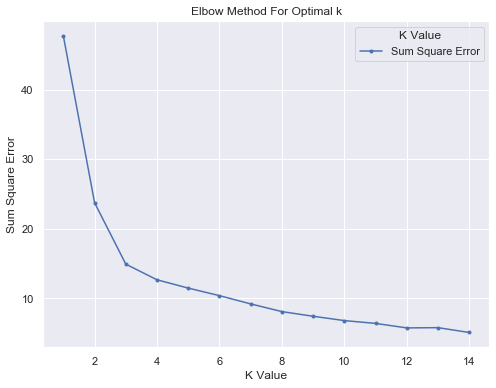

In [33]:
#optimal_k
optimal_k.plot(kind = 'line', figsize = (8, 6), marker = '.')
plt.xlabel('K Value')
plt.ylabel('Sum Square Error')
plt.title('Elbow Method For Optimal k')
plt.show()

In [34]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(jakarta_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 1, 0, 1, 0, 0, 1, 0, 1], dtype=int32)

### Put cluster labels in our neighborhood venues data

In [35]:
jakarta_merge1 = neigh_venues_sorted

# add clustering labels
jakarta_merge1['Cluster Labels'] = kmeans.labels_

jakarta_merge1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,BALEKAMBANG,Fast Food Restaurant,Wings Joint,Ice Cream Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0
1,BALI MESTER,Fast Food Restaurant,Bakery,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0
2,BANGKA,Comfort Food Restaurant,Hookah Bar,Fast Food Restaurant,Cocktail Bar,Food & Drink Shop,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,1
3,BATUAMPAR,Fast Food Restaurant,Bakery,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0
4,BENDUNGAN HILIR,Indonesian Restaurant,Fast Food Restaurant,Pizza Place,Restaurant,Spa,Japanese Restaurant,Café,Nightclub,Deli / Bodega,Dessert Shop,1
...,...,...,...,...,...,...,...,...,...,...,...,...
126,TANJUNG BARAT,Fast Food Restaurant,Wings Joint,Ice Cream Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0
127,TANJUNG DUREN SELATAN,Fast Food Restaurant,Wings Joint,Ice Cream Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0
128,TEBET TIMUR,Bakery,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Fast Food Restaurant,2
129,TEGAL ALUR,Fast Food Restaurant,Wings Joint,Ice Cream Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0


In [36]:
jakarta_fill_df=df_jakarta_3.filter(['PostalCode','Latitude','Longitude','Subdistricts','Regency'], axis=1)

In [37]:
jakarta_merge2 = jakarta_fill_df.join(jakarta_merge1.set_index('Neighborhood'), on='Subdistricts')

In [38]:
jakarta_merge3= jakarta_merge2
jakarta_merge3

,PostalCode,Latitude,Longitude,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,10110,-6.176077,106.826741,GAMBIR,JAKARTA PUSAT,Fast Food Restaurant,Indonesian Restaurant,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0.0
1,10120,-6.162689,106.827249,KEBON KELAPA,JAKARTA PUSAT,Chinese Restaurant,Seafood Restaurant,Fast Food Restaurant,Asian Restaurant,Padangnese Restaurant,Juice Bar,Sundanese Restaurant,Wings Joint,Dessert Shop,Dim Sum Restaurant,1.0
2,10130,-6.165015,106.818619,PETOJO UTARA,JAKARTA PUSAT,Fast Food Restaurant,Asian Restaurant,Restaurant,Japanese Restaurant,Donut Shop,Chinese Restaurant,Seafood Restaurant,Noodle House,Coffee Shop,Café,1.0
3,10140,-6.165196,106.810215,DURI PULO,JAKARTA PUSAT,Indonesian Restaurant,Chinese Restaurant,Café,Soup Place,Indian Restaurant,Hotel Bar,Pizza Place,Bakery,Halal Restaurant,Restaurant,1.0
4,10150,-6.167774,106.812574,CIDENG,JAKARTA PUSAT,Indonesian Restaurant,Bakery,Soup Place,Noodle House,Food Truck,Pizza Place,Restaurant,Coffee Shop,Chinese Restaurant,Café,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,14520,-5.800607,106.503420,PULAU PARI,KEPULAUAN SERIBU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,14520,-5.800607,106.503420,PULAU TIDUNG,KEPULAUAN SERIBU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
264,14530,-6.175394,106.827183,PULAU PANGGANG,KEPULAUAN SERIBU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265,14540,-6.175394,106.827183,PULAU HARAPAN,KEPULAUAN SERIBU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# drop Null Values
jakarta_merge4=jakarta_merge3.dropna(how='any')

jakarta_merge4['Cluster Labels'] = jakarta_merge4['Cluster Labels'].astype(int)

jakarta_merge4

/Users/Elizabeth/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,PostalCode,Latitude,Longitude,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,10110,-6.176077,106.826741,GAMBIR,JAKARTA PUSAT,Fast Food Restaurant,Indonesian Restaurant,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0
1,10120,-6.162689,106.827249,KEBON KELAPA,JAKARTA PUSAT,Chinese Restaurant,Seafood Restaurant,Fast Food Restaurant,Asian Restaurant,Padangnese Restaurant,Juice Bar,Sundanese Restaurant,Wings Joint,Dessert Shop,Dim Sum Restaurant,1
2,10130,-6.165015,106.818619,PETOJO UTARA,JAKARTA PUSAT,Fast Food Restaurant,Asian Restaurant,Restaurant,Japanese Restaurant,Donut Shop,Chinese Restaurant,Seafood Restaurant,Noodle House,Coffee Shop,Café,1
3,10140,-6.165196,106.810215,DURI PULO,JAKARTA PUSAT,Indonesian Restaurant,Chinese Restaurant,Café,Soup Place,Indian Restaurant,Hotel Bar,Pizza Place,Bakery,Halal Restaurant,Restaurant,1
4,10150,-6.167774,106.812574,CIDENG,JAKARTA PUSAT,Indonesian Restaurant,Bakery,Soup Place,Noodle House,Food Truck,Pizza Place,Restaurant,Coffee Shop,Chinese Restaurant,Café,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,14420,-6.138238,106.833466,PADEMANGAN BARAT,JAKARTA UTARA,Fast Food Restaurant,Hotel Bar,Ice Cream Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0
256,14440,-6.125788,106.790624,PENJARINGAN,JAKARTA UTARA,Fast Food Restaurant,Bakery,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0
257,14450,-6.121104,106.780021,PEJAGALAN,JAKARTA UTARA,Fast Food Restaurant,Bakery,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0
259,14460,-6.123993,106.762436,KAPUK MUARA,JAKARTA UTARA,Fast Food Restaurant,Wings Joint,Ice Cream Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0


### Visualized Neighborhood 

In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(jakarta_merge4['Latitude'], jakarta_merge4['Longitude'], jakarta_merge4['Subdistricts'], jakarta_merge4['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine each of the clusters 

In [41]:
# Cluster 1

cluster1=jakarta_merge4.loc[jakarta_merge4['Cluster Labels'] == 0, jakarta_merge4.columns[[0] + list(range(3, jakarta_merge4.shape[1]))]]
cluster1

,PostalCode,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,10110,GAMBIR,JAKARTA PUSAT,Fast Food Restaurant,Indonesian Restaurant,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0
20,10430,KENARI,JAKARTA PUSAT,Fast Food Restaurant,Coffee Shop,Indonesian Restaurant,Fried Chicken Joint,Food Truck,Food Court,Wings Joint,Dessert Shop,Dim Sum Restaurant,Diner,0
29,10560,JOHAR BARU,JAKARTA PUSAT,Fast Food Restaurant,Wings Joint,Ice Cream Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0
49,11160,MAPHAR,JAKARTA BARAT,Fast Food Restaurant,Wings Joint,Ice Cream Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0
51,11180,MANGGA BESAR,JAKARTA BARAT,Fast Food Restaurant,Hotel Bar,Ice Cream Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0
56,11250,JEMBATAN LIMA,JAKARTA BARAT,Fast Food Restaurant,Wings Joint,Ice Cream Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0
58,11270,DURI SELATAN,JAKARTA BARAT,Fast Food Restaurant,Wings Joint,Ice Cream Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0
61,11320,JEMBATAN BESI,JAKARTA BARAT,Fast Food Restaurant,Wings Joint,Ice Cream Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0
64,11420,KOTA BAMBU SELATAN,JAKARTA BARAT,Fast Food Restaurant,Wings Joint,Ice Cream Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0
69,11460,JELAMBAR,JAKARTA BARAT,Fast Food Restaurant,Wings Joint,Ice Cream Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,0


In [42]:
# Cluster 2
cluster2=jakarta_merge4.loc[jakarta_merge4['Cluster Labels'] == 1, jakarta_merge4.columns[[0] + list(range(3, jakarta_merge4.shape[1]))]]
cluster2

,PostalCode,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
1,10120,KEBON KELAPA,JAKARTA PUSAT,Chinese Restaurant,Seafood Restaurant,Fast Food Restaurant,Asian Restaurant,Padangnese Restaurant,Juice Bar,Sundanese Restaurant,Wings Joint,Dessert Shop,Dim Sum Restaurant,1
2,10130,PETOJO UTARA,JAKARTA PUSAT,Fast Food Restaurant,Asian Restaurant,Restaurant,Japanese Restaurant,Donut Shop,Chinese Restaurant,Seafood Restaurant,Noodle House,Coffee Shop,Café,1
3,10140,DURI PULO,JAKARTA PUSAT,Indonesian Restaurant,Chinese Restaurant,Café,Soup Place,Indian Restaurant,Hotel Bar,Pizza Place,Bakery,Halal Restaurant,Restaurant,1
4,10150,CIDENG,JAKARTA PUSAT,Indonesian Restaurant,Bakery,Soup Place,Noodle House,Food Truck,Pizza Place,Restaurant,Coffee Shop,Chinese Restaurant,Café,1
5,10160,PETOJO SELATAN,JAKARTA PUSAT,Restaurant,Manadonese Restaurant,Indonesian Restaurant,Coffee Shop,Noodle House,Food Court,Soup Place,Dessert Shop,Dim Sum Restaurant,Diner,1
6,10210,BENDUNGAN HILIR,JAKARTA PUSAT,Indonesian Restaurant,Fast Food Restaurant,Pizza Place,Restaurant,Spa,Japanese Restaurant,Café,Nightclub,Deli / Bodega,Dessert Shop,1
7,10220,KARET TENGSIN,JAKARTA PUSAT,Japanese Restaurant,Coffee Shop,Restaurant,Hotel Bar,Indonesian Restaurant,Pizza Place,Lounge,Steakhouse,Café,Fast Food Restaurant,1
8,10230,KEBON MELATI,JAKARTA PUSAT,Indonesian Meatball Place,Indonesian Restaurant,Soup Place,Wings Joint,Food & Drink Shop,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,1
9,10240,KEBON KACANG,JAKARTA PUSAT,Coffee Shop,Sushi Restaurant,Asian Restaurant,Café,Wine Bar,Bakery,Chinese Restaurant,Comfort Food Restaurant,Japanese Restaurant,Restaurant,1
10,10250,KAMPUNG BALI,JAKARTA PUSAT,Fast Food Restaurant,Indonesian Restaurant,Food Court,Asian Restaurant,Chinese Restaurant,Bed & Breakfast,Café,Betawinese Restaurant,Food Truck,Wings Joint,1


In [43]:
# Cluster 3

cluster3=jakarta_merge4.loc[jakarta_merge4['Cluster Labels'] == 2, jakarta_merge4.columns[[0] + list(range(3, jakarta_merge4.shape[1]))]]
cluster3

,PostalCode,Subdistricts,Regency,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
100,12110,SELONG,JAKARTA SELATAN,Bakery,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Fast Food Restaurant,2
102,12130,KRAMAT PELA,JAKARTA SELATAN,Bakery,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Fast Food Restaurant,2
107,12170,PETOGOGAN,JAKARTA SELATAN,Bakery,Juice Bar,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,2
113,12240,KEBAYORAN LAMA SELATAN,JAKARTA SELATAN,Bakery,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Fast Food Restaurant,2
118,12310,PONDOK PINANG,JAKARTA SELATAN,Bakery,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Fast Food Restaurant,2
121,12410,CIPETE SELATAN,JAKARTA SELATAN,Bakery,Fast Food Restaurant,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,2
139,12710,KUNINGAN BARAT,JAKARTA SELATAN,Bakery,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Fast Food Restaurant,2
142,12740,KALIBATA,JAKARTA SELATAN,Bakery,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Fast Food Restaurant,2
144,12760,DUREN TIGA,JAKARTA SELATAN,Bakery,Fast Food Restaurant,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,2
151,12820,TEBET TIMUR,JAKARTA SELATAN,Bakery,Wings Joint,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Fast Food Restaurant,2


In [ ]:
cluster1.to_excel('cluster 1.xlsx', index = False)
cluster2.to_excel('cluster 2.xlsx', index = False)
cluster3.to_excel('cluster 3.xlsx', index = False)
print ("export done!")

### Conclusion

Recommendation based on top 100 food venue in Jakarta has been presented above. Jakarta multi-cultural background population would be perfect for food lover who want to experience many kind of food.

Jakarta neighborhood segmented to 3 cluster based on recommendation of machine learning algorithm. On cluster 1, Fast Food Restaurant dominate top venue, Indonesian Restaurant for cluster 2, Bakery for cluster 3.

I have collected around 35% top ranking food venue in Jakarta due to limitation of free version of Foursquare API. The result might significantly different from presented above when using full version.